In [1]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc"><h2>--- Day 7: Some Assembly Required ---</h2><p>This year, Santa brought little Bobby Tables a set of wires and <a href="https://en.wikipedia.org/wiki/Bitwise_operation">bitwise logic gates</a>!  Unfortunately, little Bobby is a little under the recommended age range, and he needs help <span title="You had one of these as a kid, right?">assembling the circuit</span>.</p>
<p>Each wire has an identifier (some lowercase letters) and can carry a <a href="https://en.wikipedia.org/wiki/16-bit">16-bit</a> signal (a number from <code>0</code> to <code>65535</code>).  A signal is provided to each wire by a gate, another wire, or some specific value. Each wire can only get a signal from one source, but can provide its signal to multiple destinations.  A gate provides no signal until all of its inputs have a signal.</p>
<p>The included instructions booklet describes how to connect the parts together: <code>x AND y -&gt; z</code> means to connect wires <code>x</code> and <code>y</code> to an AND gate, and then connect its output to wire <code>z</code>.</p>
<p>For example:</p>
<ul>
<li><code>123 -&gt; x</code> means that the signal <code>123</code> is provided to wire <code>x</code>.</li>
<li><code>x AND y -&gt; z</code> means that the <a href="https://en.wikipedia.org/wiki/Bitwise_operation#AND">bitwise AND</a> of wire <code>x</code> and wire <code>y</code> is provided to wire <code>z</code>.</li>
<li><code>p LSHIFT 2 -&gt; q</code> means that the value from wire <code>p</code> is <a href="https://en.wikipedia.org/wiki/Logical_shift">left-shifted</a> by <code>2</code> and then provided to wire <code>q</code>.</li>
<li><code>NOT e -&gt; f</code> means that the <a href="https://en.wikipedia.org/wiki/Bitwise_operation#NOT">bitwise complement</a> of the value from wire <code>e</code> is provided to wire <code>f</code>.</li>
</ul>
<p>Other possible gates include <code>OR</code> (<a href="https://en.wikipedia.org/wiki/Bitwise_operation#OR">bitwise OR</a>) and <code>RSHIFT</code> (<a href="https://en.wikipedia.org/wiki/Logical_shift">right-shift</a>).  If, for some reason, you'd like to <em>emulate</em> the circuit instead, almost all programming languages (for example, <a href="https://en.wikipedia.org/wiki/Bitwise_operations_in_C">C</a>, <a href="https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Operators/Bitwise_Operators">JavaScript</a>, or <a href="https://wiki.python.org/moin/BitwiseOperators">Python</a>) provide operators for these gates.</p>
<p>For example, here is a simple circuit:</p>
<pre><code>123 -&gt; x
456 -&gt; y
x AND y -&gt; d
x OR y -&gt; e
x LSHIFT 2 -&gt; f
y RSHIFT 2 -&gt; g
NOT x -&gt; h
NOT y -&gt; i
</code></pre>
<p>After it is run, these are the signals on the wires:</p>
<pre><code>d: 72
e: 507
f: 492
g: 114
h: 65412
i: 65079
x: 123
y: 456
</code></pre>
<p>In little Bobby's kit's instructions booklet (provided as your puzzle input), what signal is ultimately provided to <em>wire <code>a</code></em>?</p>
</article>


x,	     123,     123,     123,     123,     123,     123,     123,     123,     123,     123
y,	     456,     456,     456,     456,     456,     456,     456,     456,     456,     456
d,	       0,      72,      72,      72,      72,      72,      72,      72,      72,      72
e,	       0,     507,     507,     507,     507,     507,     507,     507,     507,     507
f,	       0,     492,     492,     492,     492,     492,     492,     492,     492,     492
g,	       0,     114,     114,     114,     114,     114,     114,     114,     114,     114
h,	   65535,   65412,   65412,   65412,   65412,   65412,   65412,   65412,   65412,   65412
i,	   65535,   65079,   65079,   65079,   65079,   65079,   65079,   65079,   65079,   65079


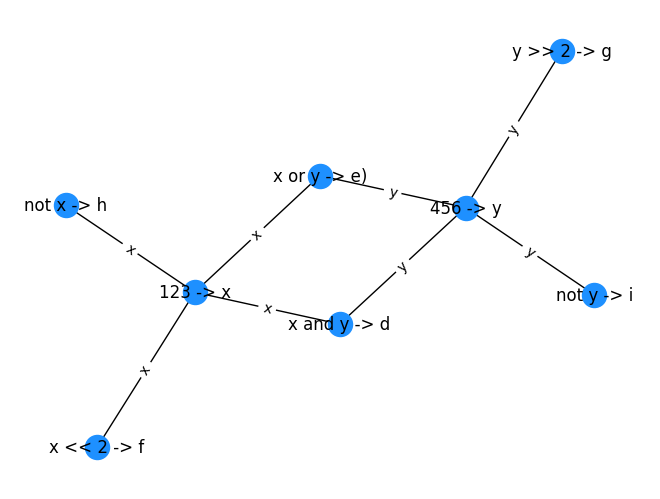

In [2]:
from tabulate import tabulate


circuit_str = """
123 -> x
456 -> y
x AND y -> d
x OR y -> e
x LSHIFT 2 -> f
y RSHIFT 2 -> g
NOT x -> h
NOT y -> i
"""


@dataclass
class Wire:
    name: str
    values: list[int] = field(repr=False)

    def step(self, t: int, value: int) -> None:
        self.values[t] = value

    def get_old(self, t: int) -> int:
        return self.values[t - 1]


@dataclass(frozen=True)
class Node:
    def step(self, t: int):
        ...


@dataclass(frozen=True, repr=False)
class Source(Node):
    wire_out: Wire
    value: int = field(repr=False)

    def step(self, t: int):
        self.wire_out.step(t, self.value)

    def __repr__(self) -> str:
        return f"{self.value} -> {self.wire_out.name}"


@dataclass(frozen=True, repr=False)
class Not(Node):
    wire_in: Wire
    wire_out: Wire

    def step(self, t: int):
        self.wire_out.step(t, self.wire_in.get_old(t) ^ 65535)

    def __repr__(self) -> str:
        return f"not {self.wire_in.name} -> {self.wire_out.name}"


@dataclass(frozen=True, repr=False)
class Id(Node):
    wire_in: Wire
    wire_out: Wire

    def step(self, t: int):
        self.wire_out.step(t, self.wire_in.get_old(t))

    def __repr__(self) -> str:
        return f"{self.wire_in.name} -> {self.wire_out.name}"


@dataclass(frozen=True, repr=False)
class LShift(Node):
    wire_in: Wire
    wire_out: Wire
    shift: int

    def step(self, t: int):
        self.wire_out.step(t, self.wire_in.get_old(t) << self.shift)

    def __repr__(self) -> str:
        return f"{self.wire_in.name} << {self.shift} -> {self.wire_out.name}"


@dataclass(frozen=True, repr=False)
class RShift(Node):
    wire_in: Wire
    wire_out: Wire
    shift: int

    def step(self, t: int):
        self.wire_out.step(t, self.wire_in.get_old(t) >> self.shift)

    def __repr__(self) -> str:
        return f"{self.wire_in.name} >> {self.shift} -> {self.wire_out.name}"


@dataclass(frozen=True, repr=False)
class And(Node):
    wire_in_left: Wire
    wire_in_right: Wire
    wire_out: Wire

    def step(self, t: int):
        self.wire_out.step(
            t, self.wire_in_left.get_old(t) & self.wire_in_right.get_old(t)
        )

    def __repr__(self) -> str:
        return f"{self.wire_in_left.name} and {self.wire_in_right.name} -> {self.wire_out.name}"


@dataclass(frozen=True, repr=False)
class Or(Node):
    wire_in_left: Wire
    wire_in_right: Wire
    wire_out: Wire

    def step(self, t: int):
        self.wire_out.step(
            t, self.wire_in_left.get_old(t) | self.wire_in_right.get_old(t)
        )

    def __repr__(self) -> str:
        return f"{self.wire_in_left.name} or {self.wire_in_right.name} -> {self.wire_out.name})"


circuit_str = """
123 -> x
456 -> y
x AND y -> d
x OR y -> e
x LSHIFT 2 -> f
y RSHIFT 2 -> g
NOT x -> h
NOT y -> i
"""


class Circuit:
    def __init__(self, circuit_str: str, steps=10) -> None:
        self.steps = steps
        nodes = []
        wires = {}
        for line in circuit_str.strip().splitlines():
            op, wire_out = re.split(r"\s+->\s+", line)

            if wire_out not in wires:
                wires[wire_out] = Wire(wire_out, [0] * steps)
            wire_out = wires[wire_out]

            if "NOT" in op:
                _, wire_in = op.split(" ")

                wire_in = self.create_wire(nodes, wires, wire_in)

                node = Not(wire_in, wire_out)

            elif "AND" in op:
                wire_in_left, _, wire_in_right = op.split(" ")

                wire_in_left = self.create_wire(nodes, wires, wire_in_left)
                wire_in_right = self.create_wire(nodes, wires, wire_in_right)

                node = And(wire_in_left, wire_in_right, wire_out)

            elif "OR" in op:
                wire_in_left, _, wire_in_right = op.split(" ")

                wire_in_left = self.create_wire(nodes, wires, wire_in_left)
                wire_in_right = self.create_wire(nodes, wires, wire_in_right)

                node = Or(wire_in_left, wire_in_right, wire_out)

            elif "LSHIFT" in op:
                wire_in, _, shift = op.split(" ")

                wire_in = self.create_wire(nodes, wires, wire_in)

                node = LShift(wire_in, wire_out, int(shift))

            elif "RSHIFT" in op:
                wire_in, _, shift = op.split(" ")

                wire_in = self.create_wire(nodes, wires, wire_in)

                node = RShift(wire_in, wire_out, int(shift))

            else:
                if op.isnumeric():
                    node = Source(wire_out, int(op))
                else:
                    wire_in = self.create_wire(nodes, wires, op)
                    node = Id(wire_in, wire_out)

            nodes.append(node)

        self.nodes = nodes
        self.wires = wires

    def create_wire(self, nodes, wires, wire_str):
        if wire_str not in wires:
            wires[wire_str] = Wire(wire_str, [0] * self.steps)

        wire = wires[wire_str]
        if wire_str.isnumeric():
            nodes.append(Source(wire, int(wire_str)))

        return wire

    def run(self):
        for t in range(self.steps):
            for node in self.nodes:
                node.step(t)

        return {wire: values.values for wire, values in self.wires.items()}

    def create_graph(self) -> dict[str, list[str]]:
        wire_goes_into = defaultdict(list)
        wire_comes_out = {}

        for node in self.nodes:
            wire_comes_out[node.wire_out.name] = node.__repr__()
            if (
                isinstance(node, Not)
                or isinstance(node, LShift)
                or isinstance(node, RShift)
            ):
                wire_goes_into[node.wire_in.name].append(node.__repr__())
            elif isinstance(node, And) or isinstance(node, Or):
                wire_goes_into[node.wire_in_left.name].append(node.__repr__())
                wire_goes_into[node.wire_in_right.name].append(node.__repr__())

        nodes = set()
        edges = []
        edge_labels = {}

        for wire, node_fr in wire_comes_out.items():
            nodes.add(node_fr)
            for node_to in wire_goes_into[wire]:
                nodes.add(node_to)
                edges.append((node_fr, node_to))
                edge_labels[(node_fr, node_to)] = wire

        return list(nodes), edges, edge_labels

    def plot(self) -> None:
        plt.close()

        nodes, edges, edge_labels = self.create_graph()
        G = nx.Graph()  # create an empty object

        G.add_nodes_from(nodes)
        G.add_edges_from(edges)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color="DodgerBlue")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()


c = Circuit(circuit_str, 10)
results = c.run()
for w, vs in results.items():
    print(f"{w},\t {', '.join(f'{v:7d}' for v in vs)}")

c.plot()

[956, 956, 956, 956, 956, 956, 956, 956, 956, 956]
ai, 	   1345,    1345,    1345,    1345,    1345,    1345,    1345,    1345,    1345,    1345
af, 	   2025,    2025,    2025,    2025,    2025,    2025,    2025,    2025,    2025,    2025
ah, 	  64855,   64855,   64855,   64855,   64855,   64855,   64855,   64855,   64855,   64855
ll, 	  64687,   64687,   64687,   64687,   64687,   64687,   64687,   64687,   64687,   64687
lk, 	    848,     848,     848,     848,     848,     848,     848,     848,     848,     848
is, 	  23555,   23555,   23555,   23555,   23555,   23555,   23555,   23555,   23555,   23555
hz, 	  47110,   47110,   47110,   47110,   47110,   47110,   47110,   47110,   47110,   47110
gp, 	  64511,   64511,   64511,   64511,   64511,   64511,   64511,   64511,   64511,   64511
go, 	   1024,    1024,    1024,    1024,    1024,    1024,    1024,    1024,    1024,    1024
dv, 	      0,       0,       0,       0,       0,       0,       0,       0,       0,       0
du, 	    

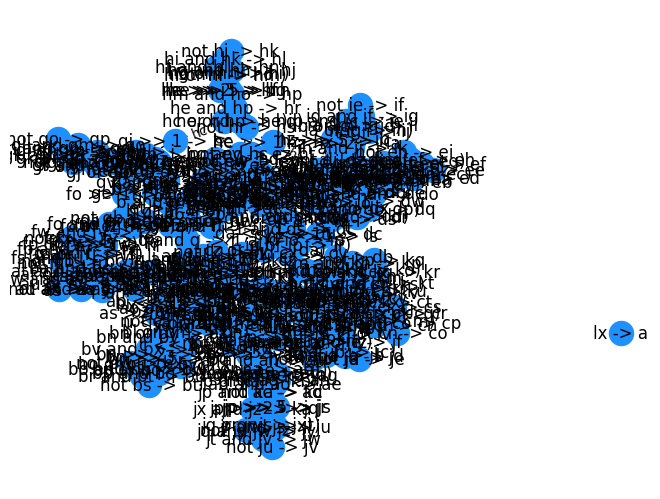

In [3]:
with open("../input/day7.txt") as f:
    circuit_str = f.read()

fc = Circuit(circuit_str, 339)

results = fc.run()
print(results["a"][-10:])
fr = 10
for w, vs in results.items():
    print(f"{w}, \t{', '.join(f'{v:7d}' for v in vs[-fr:])}")

fc.plot()

<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>956</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>Now, take the signal you got on wire <code>a</code>, override wire <code>b</code> to that signal, and reset the other wires (including wire <code>a</code>).  What new signal is ultimately provided to wire <code>a</code>?</p>
</article>
</main>


In [4]:
a = fc.wires["a"].values[-1]
for w in fc.wires:
    fc.wires[w].values = [0] * len(fc.wires[w].values)

i, n = [
    (i, n)
    for i, n in enumerate(fc.nodes)
    if isinstance(n, Source) and n.wire_out.name == "b"
][0]
fc.nodes[i] = Source(n.wire_out, a)
print(fc.wires["a"].values[-1])
fc.run()

print(fc.wires["a"].values[-1])

0
40149


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>40149</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>
<p>At this point, you should <a href="/2015">return to your Advent calendar</a> and try another puzzle.</p>
<p>If you still want to see it, you can <a href="7/input" target="_blank">get your puzzle input</a>.</p>
<p>You can also <span class="share">[Share<span class="share-content">on
  <a href="https://twitter.com/intent/tweet?text=I%27ve+completed+%22Some+Assembly+Required%22+%2D+Day+7+%2D+Advent+of+Code+2015&amp;url=https%3A%2F%2Fadventofcode%2Ecom%2F2015%2Fday%2F7&amp;related=ericwastl&amp;hashtags=AdventOfCode" target="_blank">Twitter</a>
  <a href="javascript:void(0);" onclick="var ms; try{ms=localStorage.getItem('mastodon.server')}finally{} if(typeof ms!=='string')ms=''; ms=prompt('Mastodon Server?',ms); if(typeof ms==='string' &amp;&amp; ms.length){this.href='https://'+ms+'/share?text=I%27ve+completed+%22Some+Assembly+Required%22+%2D+Day+7+%2D+Advent+of+Code+2015+%23AdventOfCode+https%3A%2F%2Fadventofcode%2Ecom%2F2015%2Fday%2F7';try{localStorage.setItem('mastodon.server',ms);}finally{}}else{return false;}" target="_blank">Mastodon</a></span>]</span> this puzzle.</p>
</main>
